## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️

# Chest X-Ray Medical Diagnosis with Deep Learning
## Part 1 - Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (**CNN**s) are the most commonly used type of neural network for computer vision tasks. They are particularly well-suited to tasks like image classification and object detection because they can automatically learn and extract relevant features from input images. 

A key feature of convolutional layers show translational invariance. This means that they can detect specific pattern independent of shifts along the data dimensions (say, for a 2D image a pattern is still detected when shifted in x or y-direction).

CNNs consist of multiple layers, each performing a different type of processing on the input data. These layers typically include convolutional layers, which extract features from the input images, and pooling layers, which downsample the output of the convolutional layers. By stacking these layers on top of one another, a CNN can learn increasingly complex representations of the input data.

We will work on the following aspects:
1. Model type and architecture
2. Model goal --> loss function and targets
3. sampling --> what data should the model see?
4. training strategy


## The dataset

For this sesseion, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of about 30,000 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
The full dataset is available for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC).

**However, we will work with a smaller subset containing about 10% of the original data!!**

In [1]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

In [4]:
# Just to check in the beginning --> later we also need the following:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

In [3]:
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Exploration

Read the metadata from `matadata.csv` and explore the data.

In [11]:
path_data = r'C:\Users\Sander\Repos\DataScience\is\ChestX_subset_small'

metadata_df = pd.read_csv(os.path.join(path_data, "metadata.csv"))
metadata_df.head()

,image,follow_up_no,patient_id,patient_age,gender,view_position,atelectasis,cardiomegaly,consolidation,edema,...,emphysema,fibrosis,hernia,infiltration,mass,no_finding,nodule,pleural_thickening,pneumonia,pneumothorax
0,00013244_008.png,8,13244,58,F,PA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00016807_023.png,23,16807,60,M,PA,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,00019988_002.png,2,19988,55,M,AP,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,00018840_022.png,22,18840,21,F,AP,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,00002072_007.png,7,2072,9,M,AP,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 1.1 Data Types and Null Values Check

Run the next cell to explore the data types present in each column and whether any null values exist in the data.
(for instance by using `.info()` or `.decribe()`)

In [ ]:
# Look at the data type of each column and whether null values are present


### 1.2 Unique IDs Check

"PatientId" has an identification number for each patient. One thing you'd like to know about a medical dataset like this is if you're looking at repeated data for certain patients or whether each image represents a different person.

In [12]:
print(
    f"The total patient ids are {metadata_df['patient_id'].count()}, \
from those the unique ids are {len(metadata_df['patient_id'].unique())}."
)

The total patient ids are 11212, from those the unique ids are 7181.


**What does this tell us?**



### 1.3 Data Labels

Run the next two code cells to create a list of the names of each patient condition or disease. 

In [13]:
columns = metadata_df.columns
print(columns.values)

['image' 'follow_up_no' 'patient_id' 'patient_age' 'gender'
 'view_position' 'atelectasis' 'cardiomegaly' 'consolidation' 'edema'
 'effusion' 'emphysema' 'fibrosis' 'hernia' 'infiltration' 'mass'
 'no_finding' 'nodule' 'pleural_thickening' 'pneumonia' 'pneumothorax']


In [14]:
# Define actual labels (or classes)
non_class_columns = ['image',
                     'follow_up_no',
                     'patient_id',
                     'patient_age',
                     'gender',
                     'view_position']
classes = [c for c in metadata_df.columns if c not in non_class_columns]

# Get the total classes
print(f"There are {len(classes)} classes (or: labels)")
print(f"This includes: {classes}")

There are 15 classes (or: labels)
This includes: ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis', 'hernia', 'infiltration', 'mass', 'no_finding', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']


In [17]:
for c in classes:
    print(metadata_df.value_counts(c))

atelectasis
0    10056
1     1156
Name: count, dtype: int64
cardiomegaly
0    10955
1      257
Name: count, dtype: int64
consolidation
0    10767
1      445
Name: count, dtype: int64
edema
0    10972
1      240
Name: count, dtype: int64
effusion
0    9900
1    1312
Name: count, dtype: int64
emphysema
0    10958
1      254
Name: count, dtype: int64
fibrosis
0    11048
1      164
Name: count, dtype: int64
hernia
0    11192
1       20
Name: count, dtype: int64
infiltration
0    9230
1    1982
Name: count, dtype: int64
mass
0    10643
1      569
Name: count, dtype: int64
no_finding
1    6070
0    5142
Name: count, dtype: int64
nodule
0    10613
1      599
Name: count, dtype: int64
pleural_thickening
0    10873
1      339
Name: count, dtype: int64
pneumonia
0    11090
1      122
Name: count, dtype: int64
pneumothorax
0    10642
1      570
Name: count, dtype: int64


In [20]:
findings = metadata_df[classes].sum()

In [23]:
findings.sort_values(ascending=False)/len(metadata_df) *100

no_finding            54.138423
infiltration          17.677488
effusion              11.701748
atelectasis           10.310382
nodule                 5.342490
pneumothorax           5.083839
mass                   5.074920
consolidation          3.968962
pleural_thickening     3.023546
cardiomegaly           2.292187
emphysema              2.265430
edema                  2.140564
fibrosis               1.462719
pneumonia              1.088120
hernia                 0.178380
dtype: float64

#### Exercise:
Have a look at the counts for the labels in each class above. Does this look like a balanced dataset?

### 1.4 Data Visualization

Using the image names listed in the csv file, you can retrieve the image associated with each row of data in your dataframe. 

Run the cell below to visualize a random selection of images from the dataset.

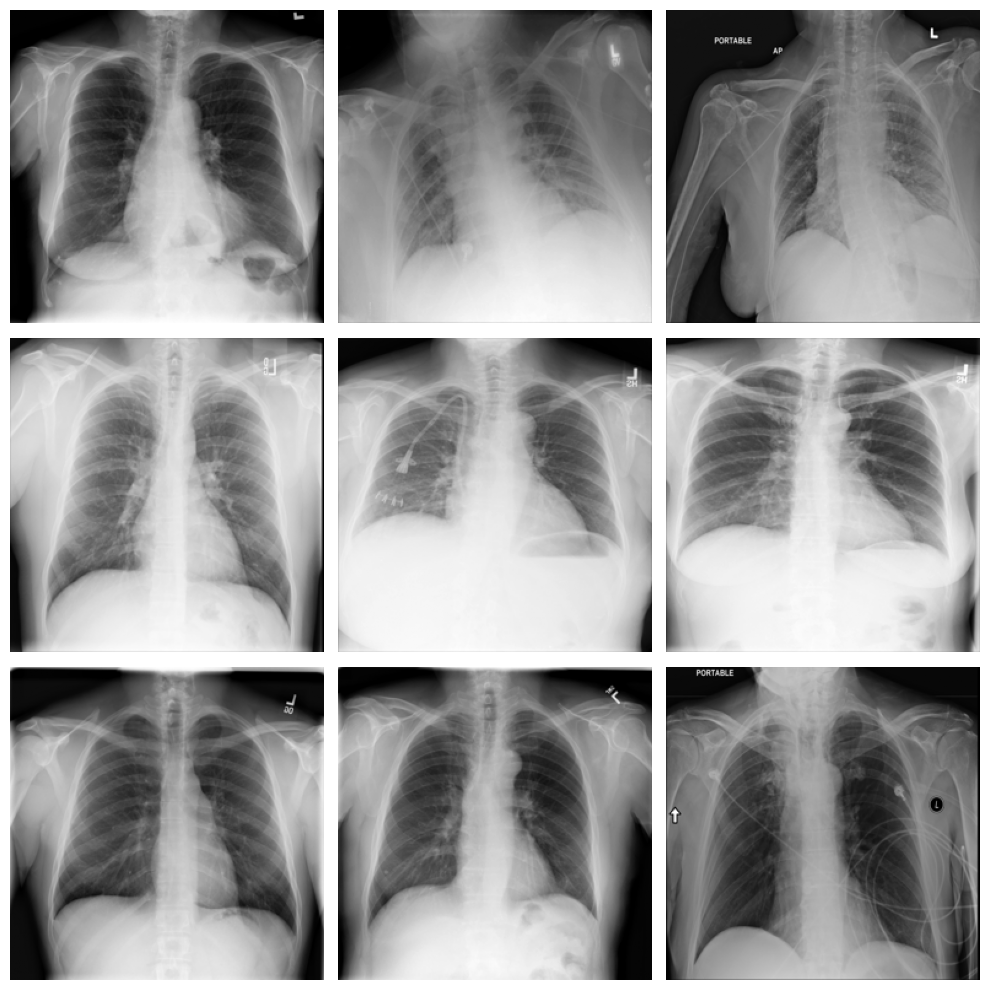

In [25]:
path_images = r'C:\Users\Sander\Repos\DataScience\is\ChestX_subset_small\images_low_resolution'

# Pick 9 random images
rng = np.random.default_rng(seed=0)  # set seed to make results reproducible
random_images = rng.choice(metadata_df.image, 9)

# Display the images
plt.figure(figsize=(10,10))

# Iterate and plot random images
for i, filename in enumerate(random_images):
    filename = filename
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(path_images, filename))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

### 1.5 Investigating a Single Image

Run the cell below to look at the first image in the dataset and print out some details of the image contents.

The dimensions of the image are (256, 256).
The maximum pixel value is 0.9765 and the minimum is 0.0000
The mean value of the pixels is 0.4614 and the standard deviation is 0.2666


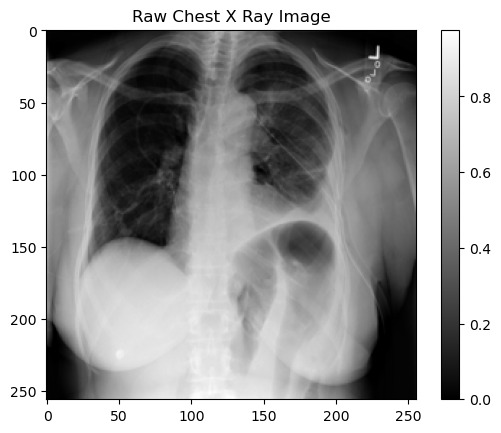

In [26]:
# Get the first image that was listed in the train_df dataframe
sample_img = metadata_df.image[0]
raw_image = plt.imread(os.path.join(path_images, sample_img))

plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {raw_image.shape}.")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

# Split the data!?
One of the most fundamental concepts in machine learning is the distinction between *training* and *test* data.
In machine learning, our models "learn" from data. But, to be able to test later how well a model performs we should never use the same data as during training. Models can *overfit*, for instance (partly) learn by heart what to do with certain data points. The model would then only appear to perform well, giving drastically different predictions on new data.

For simpler machine learning scenarios it is often enough to reserve part of the data as a **test set**.

In deep learning, however, we commonly need two different types of test sets: One is called **validation set** and is used to optimize our model and the training, while a second **test set** is kept until the end of an optimization period for a final test of a model.

In [27]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    metadata_df,
    test_size=0.15,
    stratify=metadata_df.atelectasis,
    random_state=0
)
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (9530, 21)
Test set size: (1682, 21)


In [ ]:
# second split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df.atelectasis,
    random_state=0
)
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")

### Can we work with this? Or are there any important issues?


## 2. Image Preprocessing with Pytorch

Before training, we will typically have to modify your images to be better suited for training a convolutional neural network.

Important questions in this context are:
- What should be the input resolution for my CNN?
- Do we work with grayscale or color (e.g., RGB) images?
- How should the pixel values be scaled, for instance integers between 0 and 255 (8-bit image data) or floats?

For this task you'll use the Pytorch [transforms](https://pytorch.org/vision/stable/transforms.html) function to perform data preprocessing and data augmentation.

Run the next two cells to import this function and create an image generator for preprocessing.

### First: Build a Pytorch Dataset

In [ ]:
# A dataset class for this case is provided in pytorch_utils.py
from pytorch_utils import XRayDataset

What data does this return?

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
train_features.shape

In [ ]:
train_features.max()

In [ ]:
path_images = "../../../Data/ChestX_subset/images_low_resolution/"

training_data = XRayDataset(#add code)
(a, b) = training_data.__getitem__(0)

In [ ]:
# what is a? what is b?

In [ ]:
import torch
from torchvision.transforms import v2

# Define image transformations that will later be applied to every image
transforms = # add code

img = train_features[0].squeeze()
img = transforms(img)
plt.imshow(img[0, :, :], cmap="gray")

In [ ]:
plt.hist(img.flatten(), bins=50, rwidth=0.8)
plt.title("Pixel values")
plt.show()

---
## Data generator with image transformation
Just to have a clean, fresh start here...

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2


transforms = #add code

In [ ]:
path_images = "add own path ... images_low_resolution/"

training_data = # add code
train_dataloader = # add code

---
# Quick intro: 2D convolutions
- Simply try out different convolution kernels and see what they do to the image.
- See also: https://en.wikipedia.org/wiki/Kernel_(image_processing)

In [ ]:
import numpy as np
from scipy.signal import convolve2d
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Create a dummy image with horizontal and vertical lines
image = np.zeros((100, 100))

# Adding horizontal lines
image[[20, 50], :] = 1
image[[85], :] = 0.4

# Adding vertical lines
image[:, 15] = 1
image[:, [70, 80, 85]] = 0.6

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Dummy image with horizontal and vertical lines')
plt.axis('off')
plt.show()

## Exercise: build your own kernels!

- Play with the numbers in the kernels.
- Create one kernel that will detect horizontal lines (this means: it will raise the values when it finds horizontal lines)
- Create one kernel that will detect crossing points between horizontal and vertical lines.

In [ ]:
# Define two simple kernels: one for horizontal lines and one for a cross
horizontal_kernel = np.array(
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
)

cross_kernel = np.array(
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
)

The following code will use your kernels:

In [ ]:
# Perform the convolution
conv_horizontal = convolve2d(image, horizontal_kernel, mode='same', boundary='fill', fillvalue=0)
conv_cross = convolve2d(image, cross_kernel, mode='same', boundary='fill', fillvalue=0)

# Display the result of the convolutions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(conv_horizontal, cmap='gray')
ax1.set_title('Convolution with Horizontal Kernel')
ax1.axis('off')

ax2.imshow(conv_cross, cmap='gray')
ax2.set_title('Convolution with Cross Kernel')
ax2.axis('off')

plt.show()

# Build a first CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = # add code

# Define model architecture


# Instantiate the model
model = CNNModel()

print(model)

## Visualize your model
Pytorch has no built-in model visualization. The output above (`print(model)`) only lists the explicitly included layers or modules but does not show the precise sizes or architecture.

One way to nicely visualize a pytorch model is via `onnx`. The onnx files can then be read using [the netron app](https://netron.app/).

In [ ]:
#!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model)

In [ ]:
#!pip install onnx onnxscript

## Train your model!

There are several ways to make it *seemingly* easy to train a deep learning model. Maybe as easy as runing code like `model.train()` or `model.fit()`.

Here this will not work. And that's a good thing!

*Why?*

Because this will force us to set up the necessary steps needed for a model training explicitly. Thereby we will (hopefully) get a better picture of what is happening during training and it will give us more control of many small details in the process.

For more information on this you can also look at the [pytorch documentation](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html).

## Key component: loss function!
We absolutely need a suitable **loss function** to train a deep learning model. This function is supposed to give a numerical value that measures how well our model performs on the given task. Using the concept of **backpropagation** the training algorithm will then adjust the model parameters in small incremental steps **in the direction towards smaller loss values**.

In reality, this is done by computing the partial derivatives of the loss function and following the resulting gradients, which tell the algorithm in which direction parameters should be adjusted (and how strongly).

In [ ]:
loss_fn = # set a loss function here

# create a (fake) prediction
prediction = nn.Sigmoid()(torch.randn(5, requires_grad=True))

# create a (fake) label
label = torch.tensor([0, 0, 1, 0, 1], dtype=torch.float)

# compute the loss
loss = loss_fn(prediction, label)

In [ ]:
# check: what is label, prediction, loss?

## Optimizer: the algorithm that leads the way
There are different ways to adjust the model parameters based on the loss function. The underlying algorithms and their implementations are called **optimizer**.

In [ ]:
# Initialize new model
model = CNNModel()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### One training step